## 策略梯度
- REINFORCE蒙特卡洛策略梯度
- 带有基线的REINFORCE
- Actor-Critic算法

![](https://gitee.com/wubmu/image/raw/master/img/20210826205725.png)

### REINFORCE代码实践
我们在Cartpole环境中进行REINFORCE算法的实验。


In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

定义策略网络PolicyNet, 输入的是状态(state),输出则是该状态下的动作分布

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.softmax(self.fc2(x),dim=1)

再定义我们的REINFORCE算法。

In [3]:
# class REINFORCE:
#     def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
#         self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
#         self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
#         self.gamma = gamma
        
#     def take_action(self, state): # 根据动作概率分布随机采样
#         state = torch.tensor([state], dtype= torch.float).to(device)
#         probs = self.policy_net(state)
#         action_dist = torch.distributions.Categorical(probs) # 创建一个分布
#         action = action_dist.sample()
#         return action.item()
    
#     def update(self, transition_dict):
#         reward_list = transition_dict['rewards']
#         state_list = transition_dict['states']
#         action_list = transition_dict['actions']
        
#         G = 0
#         self.optimizer.zero_grad()
#         for i in reversed(range(len(reward_list))): # 从最后一步算起
#             reward = reward_list[i]
#             state = torch.tensor([state_list[i]], dtype=torch.float)
#             action = torch.tensor([action_list[i]]).view(-1, 1)
            
#             # 计算策略梯度
#             log_prob = torch.log(self.policy_net(state).gather(1, action))
#             G = self.gamma * G + reward
#             loss = -log_prob * G # 每一步的损失函数
#             loss.backward() #  反向传播计算梯度，累计梯度到一个序列结束
        
#         self.optimizer.step() # 梯度下降


class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer= torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate) # 使用Adam优化器
        self.gamma = gamma # 折扣因子

    def take_action(self, state): # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))): # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = - log_prob * G # 每一步的损失函数
            loss.backward() # 反向传播计算梯度
        self.optimizer.step() # 梯度下降

Episode: 50, Score: 19.8
Episode: 100, Score: 33.1
Episode: 150, Score: 40.8
Episode: 200, Score: 72.6
Episode: 250, Score: 122.2
Episode: 300, Score: 124.5
Episode: 350, Score: 118.3
Episode: 400, Score: 151.3
Episode: 450, Score: 187.4
Episode: 500, Score: 183.3
Episode: 550, Score: 178.6
Episode: 600, Score: 174.0
Episode: 650, Score: 184.0
Episode: 700, Score: 167.6
Episode: 750, Score: 184.1
Episode: 800, Score: 198.0
Episode: 850, Score: 191.5
Episode: 900, Score: 196.3
Episode: 950, Score: 197.9
Episode: 1000, Score: 182.0


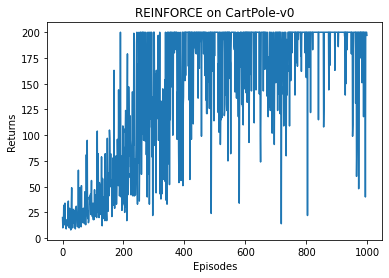

In [6]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)


return_list = [] # 记录每一条序列的回报
for i_episode in range(num_episodes):
    episode_return = 0
    transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[],'dones':[]}
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        
        
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)
        
        state = next_state
        episode_return += reward
    return_list.append(episode_return)
    agent.update(transition_dict)
    if (i_episode + 1)%50 == 0:
        print("Episode: {}, Score: {}".format(i_episode+1, np.mean(return_list[-10:])))
        
        
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format('CartPole-v0'))
plt.show()

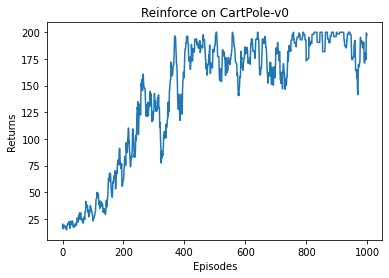

In [7]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Reinforce on {}'.format(env_name))
plt.show()

In [5]:
from tqdm import tqdm
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 7:   3%|██▉                                                                                             | 3/100 [00:00<00:24,  3.93it/s]


KeyboardInterrupt: 